In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.stats import poisson

def norm(x, mean):
    return np.exp(-(x-mean)**2/2/mean) / np.sqrt(2*np.pi*mean)

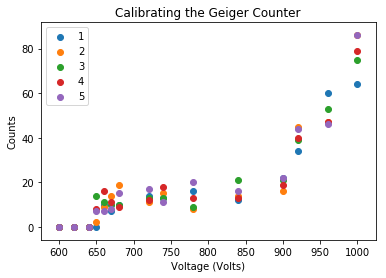

In [2]:
df = pd.read_excel('geiger_calibration.xlsx')
X = df.values
for i in range(1, len(X[0])):
    plt.scatter(X[:, 0], X[:,i])
    
plt.title('Calibrating the Geiger Counter')
plt.ylabel('Counts')
plt.xlabel('Voltage (Volts)')
plt.legend([1,2,3,4,5])
plt.show()

                   mean      std      var  mean error  var error    delta  \
mean               2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
std                2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
var                2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
mean error         2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
var error          2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
delta              2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
delta uncertainty  2.25  1.61954  2.62291    0.086603   0.162289  0.37291   

                   delta uncertainty  
mean                        0.183951  
std                         0.183951  
var                         0.183951  
mean error                  0.183951  
var error                   0.183951  
delta                       0.183951  
delta uncertainty           0.183951  

raw bins [0 1 2 3 4 5 6 7 9] 
raw counts [37 68 84 53 30 16  6  5  1]


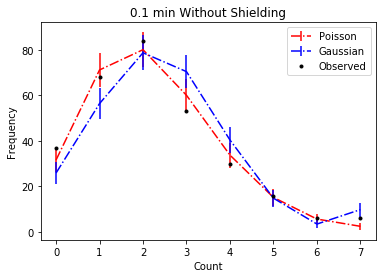

In [3]:
# load data and format for analysis
df1 = pd.read_excel('0.1min_interval_geiger.xlsx', header=None)
params = df1[0].describe()
N = params[0]
mean = params[1]
std = params[2]
var = params[2]**2
mean_uncertainty = np.sqrt(mean)/np.sqrt(N)
var_uncertainty = np.sqrt(2*mean**2-mean)/np.sqrt(N-1)
metrics = {}
metrics.update({'mean':mean})
metrics.update({'std':std})
metrics.update({'var':var})
metrics.update({'mean error':mean_uncertainty})
metrics.update({'var error': var_uncertainty})
metrics.update({'delta': abs(mean-var)})
metrics.update({'delta uncertainty': np.sqrt(mean_uncertainty**2 + var_uncertainty**2)})
metrics = pd.DataFrame(data=metrics, index=metrics.keys())
print(metrics)


counts = df1.values
counts = np.ndarray.flatten(counts)
x, y = np.unique(counts, return_counts=True)
print('\nraw bins', x, '\nraw counts', y)

pvals = []
Counts = []
# rewrite this loop to obtain left probability values
for i in range(7):
    pvals.append([poisson.pmf(i, mean), norm(i, mean)])
    Counts.append(y[i])

Counts.append(0)
# adjust the condition to find the right tail bin count
Counts[-1] = np.sum(y[np.argwhere(x>=7)])

    
print('\nBinned counts',Counts)
    
temp = np.array(pvals)
pvals.append([1-np.sum(temp[:,0]), 1-np.sum(temp[:,1])])

temp = np.array(pvals)
print('\n','these should be 1',np.sum(temp[:,0]), np.sum(temp[:,1]))

bin_uncertainties = []
for p, g in pvals:
    bin_uncertainties.append([np.sqrt(N*p*(1-p)), np.sqrt(N*g*(1-g))])
    
temp = np.array(bin_uncertainties)

print('\n\n Poisson uncertainties',temp[:,0], '\n\nGaussian uncertainties', temp[:,1], '\n')

x = np.arange(x[0], x[0]+len(temp))

print('\n\nThese should be equal', len(Counts), len(bin_uncertainties), len(x), len(pvals))

bin_uncertainties = np.array(bin_uncertainties)
pvals = np.array(pvals)
Counts = np.array(Counts)

fvals = N*np.array(pvals)

chi2 = []

for f, o, sigma in zip(fvals, Counts, bin_uncertainties):
    pchi = ((f[0]-o)/sigma[0])**2
    gchi = ((f[1]-o)/sigma[1])**2
    chi2.append([pchi,gchi])
    
chi2 = np.array(chi2)

chi2p = np.sum(chi2[:,0])
chi2g = np.sum(chi2[:,1])

print('\n\n')
print('The poisson Chi2 is {}, the gaussian Chi2 is {}, the expected Chi2 is {}, with deviation {}'.format(chi2p, chi2g, len(Counts)-1, np.sqrt(2*(len(Counts)-1))))
print('\n\n')
plt.errorbar(x, fvals[:,0], yerr=bin_uncertainties[:,0], fmt='-.r')
plt.errorbar(x, fvals[:,1], yerr=bin_uncertainties[:,1], fmt='-.b')
plt.errorbar(x, Counts, fmt='.k')
plt.title('0.1 min Without Shielding')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend(['Poisson', 'Gaussian', 'Observed'])
plt.show()

                        mean       std        var  mean error  var error  \
mean               23.383333  4.603211  21.189548    0.624277   4.258943   
std                23.383333  4.603211  21.189548    0.624277   4.258943   
var                23.383333  4.603211  21.189548    0.624277   4.258943   
mean error         23.383333  4.603211  21.189548    0.624277   4.258943   
var error          23.383333  4.603211  21.189548    0.624277   4.258943   
delta              23.383333  4.603211  21.189548    0.624277   4.258943   
delta uncertainty  23.383333  4.603211  21.189548    0.624277   4.258943   

                      delta  delta uncertainty  
mean               2.193785           4.304453  
std                2.193785           4.304453  
var                2.193785           4.304453  
mean error         2.193785           4.304453  
var error          2.193785           4.304453  
delta              2.193785           4.304453  
delta uncertainty  2.193785           4.304453  

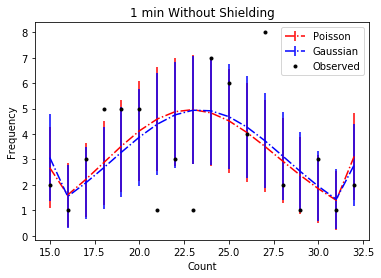

In [4]:
# load data and format for analysis
df1 = pd.read_excel('1min_interval_geiger.xlsx', header=None)
params = df1[0].describe()
N = params[0]
mean = params[1]
std = params[2]
var = params[2]**2
mean_uncertainty = np.sqrt(mean)/np.sqrt(N)
var_uncertainty = np.sqrt(2*mean**2-mean)/np.sqrt(N-1)
metrics = {}
metrics.update({'mean':mean})
metrics.update({'std':std})
metrics.update({'var':var})
metrics.update({'mean error':mean_uncertainty})
metrics.update({'var error': var_uncertainty})
metrics.update({'delta': abs(mean-var)})
metrics.update({'delta uncertainty': np.sqrt(mean_uncertainty**2 + var_uncertainty**2)})
metrics = pd.DataFrame(data=metrics, index=metrics.keys())
print(metrics)


counts = df1.values
counts = np.ndarray.flatten(counts)
x, y = np.unique(counts, return_counts=True)
print('\nraw bins', x, '\nraw counts', y)

pval = 0
gval = 0
for i in range(16):
    pval += poisson.pmf(i, mean)
    gval += norm(i, mean)

pvals = [[pval,gval]]
Counts = [y[0]]
# rewrite this loop to obtain left probability values
for i in range(16, 32):
    pvals.append([poisson.pmf(i, mean), norm(i, mean)])
    Counts.append(y[np.argwhere(x==i)[0][0]])

Counts.append(0)
# adjust the condition to find the right tail bin count
Counts[-1] = np.sum(y[np.argwhere(x>=32)])
    
print('\nBinned counts',Counts)
    
temp = np.array(pvals)
pvals.append([1-np.sum(temp[:,0]), 1-np.sum(temp[:,1])])

temp = np.array(pvals)
print('\n','these should be 1',np.sum(temp[:,0]), np.sum(temp[:,1]))

bin_uncertainties = []
for p, g in pvals:
    bin_uncertainties.append([np.sqrt(N*p*(1-p)), np.sqrt(N*g*(1-g))])
    
temp = np.array(bin_uncertainties)

print('\n\n Poisson uncertainties',temp[:,0], '\n\nGaussian uncertainties', temp[:,1], '\n')

x = np.arange(x[0], x[0]+len(temp))

print('\n\nThese should be equal', len(Counts), len(bin_uncertainties), len(x), len(pvals))

bin_uncertainties = np.array(bin_uncertainties)
pvals = np.array(pvals)
Counts = np.array(Counts)

fvals = N*np.array(pvals)

chi2 = []

for f, o, sigma in zip(fvals, Counts, bin_uncertainties):
    pchi = ((f[0]-o)/sigma[0])**2
    gchi = ((f[1]-o)/sigma[1])**2
    chi2.append([pchi,gchi])
    
chi2 = np.array(chi2)

chi2p = np.sum(chi2[:,0])
chi2g = np.sum(chi2[:,1])

print('\n\n')
print('The poisson Chi2 is {}, the gaussian Chi2 is {}, the expected Chi2 is {}, with deviation {}'.format(chi2p, chi2g, len(Counts)-1, np.sqrt(2*(len(Counts)-1))))
print('\n\n')
plt.errorbar(x, fvals[:,0], yerr=bin_uncertainties[:,0], fmt='-.r')
plt.errorbar(x, fvals[:,1], yerr=bin_uncertainties[:,1], fmt='-.b')
plt.errorbar(x, Counts, fmt='.k')
plt.title('1 min Without Shielding')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend(['Poisson', 'Gaussian', 'Observed'])
plt.show()

                       mean       std       var  mean error  var error  \
mean               1.296774  1.037636  1.076689    0.064677   0.081778   
std                1.296774  1.037636  1.076689    0.064677   0.081778   
var                1.296774  1.037636  1.076689    0.064677   0.081778   
mean error         1.296774  1.037636  1.076689    0.064677   0.081778   
var error          1.296774  1.037636  1.076689    0.064677   0.081778   
delta              1.296774  1.037636  1.076689    0.064677   0.081778   
delta uncertainty  1.296774  1.037636  1.076689    0.064677   0.081778   

                      delta  delta uncertainty  
mean               0.220086           0.104263  
std                0.220086           0.104263  
var                0.220086           0.104263  
mean error         0.220086           0.104263  
var error          0.220086           0.104263  
delta              0.220086           0.104263  
delta uncertainty  0.220086           0.104263  

raw bins [0 1 

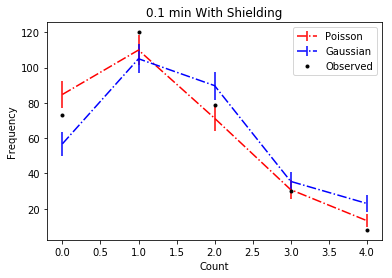

In [5]:
# load data and format for analysis
df1 = pd.read_excel('0.1min_interval_geiger_shield.xlsx', header=None)
params = df1[0].describe()
N = params[0]
mean = params[1]
std = params[2]
var = params[2]**2
mean_uncertainty = np.sqrt(mean)/np.sqrt(N)
var_uncertainty = np.sqrt(2*mean**2-mean)/np.sqrt(N-1)
metrics = {}
metrics.update({'mean':mean})
metrics.update({'std':std})
metrics.update({'var':var})
metrics.update({'mean error':mean_uncertainty})
metrics.update({'var error': var_uncertainty})
metrics.update({'delta': abs(mean-var)})
metrics.update({'delta uncertainty': np.sqrt(mean_uncertainty**2 + var_uncertainty**2)})
metrics = pd.DataFrame(data=metrics, index=metrics.keys())
print(metrics)


counts = df1.values
counts = np.ndarray.flatten(counts)
x, y = np.unique(counts, return_counts=True)
print('\nraw bins', x, '\nraw counts', y)


pvals = []
Counts = []
# rewrite this loop to obtain left probability values
for i in range(4):
    pvals.append([poisson.pmf(i, mean), norm(i, mean)])
    Counts.append(y[i])

Counts.append(0)
# adjust the condition to find the right tail bin count
Counts[-1] = np.sum(y[np.argwhere(x>=4)])

    
print('\nBinned counts',Counts)
    
temp = np.array(pvals)
pvals.append([1-np.sum(temp[:,0]), 1-np.sum(temp[:,1])])

temp = np.array(pvals)
print('\n','these should be 1',np.sum(temp[:,0]), np.sum(temp[:,1]))

bin_uncertainties = []
for p, g in pvals:
    bin_uncertainties.append([np.sqrt(N*p*(1-p)), np.sqrt(N*g*(1-g))])
    
temp = np.array(bin_uncertainties)

print('\n\n Poisson uncertainties',temp[:,0], '\n\nGaussian uncertainties', temp[:,1], '\n')

x = np.arange(x[0], x[0]+len(temp))

print('\n\nThese should be equal', len(Counts), len(bin_uncertainties), len(x), len(pvals))

bin_uncertainties = np.array(bin_uncertainties)
pvals = np.array(pvals)
Counts = np.array(Counts)

fvals = N*np.array(pvals)

chi2 = []

for f, o, sigma in zip(fvals, Counts, bin_uncertainties):
    pchi = ((f[0]-o)/sigma[0])**2
    gchi = ((f[1]-o)/sigma[1])**2
    chi2.append([pchi,gchi])
    
chi2 = np.array(chi2)

chi2p = np.sum(chi2[:,0])
chi2g = np.sum(chi2[:,1])

print('\n\n')
print('The poisson Chi2 is {}, the gaussian Chi2 is {}, the expected Chi2 is {}, with deviation {}'.format(chi2p, chi2g, len(Counts)-1, np.sqrt(2*(len(Counts)-1))))
print('\n\n')
plt.errorbar(x, fvals[:,0], yerr=bin_uncertainties[:,0], fmt='-.r')
plt.errorbar(x, fvals[:,1], yerr=bin_uncertainties[:,1], fmt='-.b')
plt.errorbar(x, Counts, fmt='.k')
plt.title('0.1 min With Shielding')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend(['Poisson', 'Gaussian', 'Observed'])
plt.show()


                         mean        std         var  mean error  var error  \
mean               237.833333  13.317908  177.366667    6.295942  150.26081   
std                237.833333  13.317908  177.366667    6.295942  150.26081   
var                237.833333  13.317908  177.366667    6.295942  150.26081   
mean error         237.833333  13.317908  177.366667    6.295942  150.26081   
var error          237.833333  13.317908  177.366667    6.295942  150.26081   
delta              237.833333  13.317908  177.366667    6.295942  150.26081   
delta uncertainty  237.833333  13.317908  177.366667    6.295942  150.26081   

                       delta  delta uncertainty  
mean               60.466667         150.392653  
std                60.466667         150.392653  
var                60.466667         150.392653  
mean error         60.466667         150.392653  
var error          60.466667         150.392653  
delta              60.466667         150.392653  
delta uncertainty

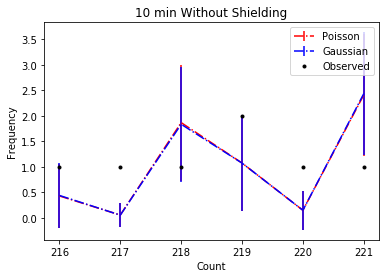

In [6]:
# load data and format for analysis
df1 = pd.read_excel('10min_interval_geiger.xlsx', header=None)
params = df1[0].describe()
N = params[0]
mean = params[1]
std = params[2]
var = params[2]**2
mean_uncertainty = np.sqrt(mean)/np.sqrt(N)
var_uncertainty = np.sqrt(2*mean**2-mean)/np.sqrt(N-1)
metrics = {}
metrics.update({'mean':mean})
metrics.update({'std':std})
metrics.update({'var':var})
metrics.update({'mean error':mean_uncertainty})
metrics.update({'var error': var_uncertainty})
metrics.update({'delta': abs(mean-var)})
metrics.update({'delta uncertainty': np.sqrt(mean_uncertainty**2 + var_uncertainty**2)})
metrics = pd.DataFrame(data=metrics, index=metrics.keys())
print(metrics)


counts = df1.values
counts = np.ndarray.flatten(counts)
x, y = np.unique(counts, return_counts=True)
print('\nraw bins', x, '\nraw counts', y)

pval = 0
gval = 0
for i in range(216):
    pval += poisson.pmf(i, mean)
    gval += norm(i, mean)

pvals = [[pval,gval]]
Counts = [y[0]]
# rewrite this loop to obtain left probability values
pval = 0
gval = 0
for i in range(216, 257):
    pval += poisson.pmf(i, mean)
    gval += norm(i, mean)
    if i in x:
        Counts.append(y[np.argwhere(x==i)[0][0]])
        pvals.append([pval, gval])
        pval = 0
        gval = 0

Counts.append(0)
# adjust the condition to find the right tail bin count
Counts[-1] = np.sum(y[np.argwhere(x>=257)])
    
print('\nBinned counts',Counts)
    
temp = np.array(pvals)
pvals.append([1-np.sum(temp[:,0]), 1-np.sum(temp[:,1])])

temp = np.array(pvals)
print('\n','these should be 1',np.sum(temp[:,0]), np.sum(temp[:,1]))

bin_uncertainties = []
for p, g in pvals:
    bin_uncertainties.append([np.sqrt(N*p*(1-p)), np.sqrt(N*g*(1-g))])
    
temp = np.array(bin_uncertainties)

print('\n\n Poisson uncertainties',temp[:,0], '\n\nGaussian uncertainties', temp[:,1], '\n')

x = np.arange(x[0], x[0]+len(temp))

print('\n\nThese should be equal', len(Counts), len(bin_uncertainties), len(x), len(pvals))

bin_uncertainties = np.array(bin_uncertainties)
pvals = np.array(pvals)
Counts = np.array(Counts)

fvals = N*np.array(pvals)

chi2 = []

for f, o, sigma in zip(fvals, Counts, bin_uncertainties):
    pchi = ((f[0]-o)/sigma[0])**2
    gchi = ((f[1]-o)/sigma[1])**2
    chi2.append([pchi,gchi])
    
chi2 = np.array(chi2)

chi2p = np.sum(chi2[:,0])
chi2g = np.sum(chi2[:,1])

print('\n\n')
print('The poisson Chi2 is {}, the gaussian Chi2 is {}, the expected Chi2 is {}, with deviation {}'.format(chi2p, chi2g, len(Counts)-1, np.sqrt(2*(len(Counts)-1))))
print('\n\n')
plt.errorbar(x, fvals[:,0], yerr=bin_uncertainties[:,0], fmt='-.r')
plt.errorbar(x, fvals[:,1], yerr=bin_uncertainties[:,1], fmt='-.b')
plt.errorbar(x, Counts, fmt='.k')
plt.title('10 min Without Shielding')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend(['Poisson', 'Gaussian', 'Observed'])
plt.show()

In [8]:
count_rates = [22.5, 23.1, 23.7]
count_rate_deviations = [10*0.087, 0.624, 0.063/10]

count_rate_deviations = np.array(count_rate_deviations)
count_rate_vars = count_rate_deviations*count_rate_deviations
print('The average count rate is {} with deviaton {}'.format(np.mean(count_rates), np.sum(count_rate_vars)))

The average count rate is 23.099999999999998 with deviaton 1.1463156899999998


In [11]:
# chi2 of chi2

chi2ps = [[7.92, 7], [20.57, 17], [6.97, 4], [24.12, 5]]
chi2gs = [[20.8, 7], [20.31, 17], [22.26, 4], [24.31, 5]]
chi2err = [np.sqrt(2*7), np.sqrt(2*17), np.sqrt(2*4), np.sqrt(2*5)]

chi2chi2 = []
for p,g,err in zip(chi2ps, chi2gs,chi2err):
    chi2p = (p[0]-p[1])**2/err**2
    chi2g = (g[0]-g[1])**2/err**2
    chi2chi2.append([chi2p,chi2g])
    
chi2chi2 = np.array(chi2chi2)
chi2p = np.sum(chi2chi2[:,0])
chi2g = np.sum(chi2chi2[:,1])
print('The chi2 of chi2 for poission is {}, for gaussian {}, the expected is {} with error {}'.format(chi2p, chi2g, 4, 2*np.sqrt(2)))

The chi2 of chi2 for poission is 38.09535964285713, for gaussian 92.89115537815124, the expected is 4 with error 2.8284271247461903
